In [1]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

import biomart
import prototypical_network
import helper_fns
import vanilla_vae
from model import PL, Net, train, train_knn, train_logistic_regression

In [2]:
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
list_celltypes = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_celltypes = list(filter(lambda x: x not in ['Mast cells', 'pDC','Progenitor', 'Erythroid', 'Megakaryocytes'], list_celltypes))
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_celltypes))
dataset_celltypist = dataset_celltypist[dataset_celltypist.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_celltypist.obs['Manually_curated_celltype'])

list_ct = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

g = helper_fns.build_hierarchical_tree_celltypist(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_celltypist, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset_celltypist[train_indices].X)
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_popv = LabelEncoder()
encoder_celltype_popv.fit(dataset_popv.obs['cell_type'])

sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
model = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
    encoder=encoder_celltype, dataset=dataset_celltypist_pca, dataloader_training=dataloader_training, dataloader_testing=dataloader_testing, 
    obs_name='Manually_curated_celltype', init_weights=weights)
embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))
helper_fns.plot_confusion_matrix('Proto_Net', model, dataset=dataset_celltypist_pca, encoder=encoder_celltype, test_indices=test_indices, obs_name='Manually_curated_celltype')

/Users/xbh0403/Desktop/HCell/model.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 22.45, time 7.1s
Test ER 15.68, time 0.5s
Epoch 2
Train ER 13.12, time 6.0s
Test ER 11.38, time 0.5s
Epoch 3
Train ER 10.31, time 6.0s
Test ER 9.90, time 0.5s
Epoch 4
Train ER 9.43, time 6.0s
Test ER 9.53, time 0.6s
Epoch 5
Train ER 8.93, time 6.0s
Test ER 9.19, time 0.6s
Epoch 6
Train ER 8.64, time 6.0s
Test ER 8.79, time 0.6s
Epoch 7
Train ER 8.37, time 6.0s
Test ER 8.79, time 0.5s
Epoch 8
Train ER 8.22, time 6.0s
Test ER 8.65, time 0.6s
Epoch 9
Train ER 8.10, time 6.0s
Test ER 8.48, time 0.5s
Epoch 10
Train ER 7.95, time 6.1s
Test ER 8.40, time 0.5s
Epoch 11
Train ER 7.90, time 6.0s
Test ER 8.40, time 0.6s
Epoch 12
Train ER 7.78, time 6.0s
Test ER 8.31, time 0.6s
Epoch 13
Train ER 7.74, time 6.0s
Test ER 8.33, time 0.5s
Epoch 14
Train ER 7.66, time 6.0s
Test ER 8.38, time 0.6s
Epoch 15
Train ER 7.61, time 6.0s
Test ER 8.32, time 0.5s
Epoch 16
Train ER 7.55, time 6.1s
Test ER 8.30, time 0.5s
Epoch 17
Train ER 7.50, time 6.2s
Test ER 8.40, time 0.6s
Epoch 18
Train ER 

KeyboardInterrupt: 

In [4]:
model_logistic = train_logistic_regression(dataset=dataset_celltypist_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='Manually_curated_celltype')
model_knn = train_knn(dataset=dataset_celltypist_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='Manually_curated_celltype')

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 7.911618240991258%
Test error: 8.378047632495534%
kNN
Train error: 7.716347096420028%
Test error: 10.809877937807899%


In [5]:
train_celltypes = ['Memory B cells', 'Naive B cells', 'Tfh', 'Plasma cells', 'Tregs']
test_celltypes = ['memory B cell', 'naive B cell', 'T follicular helper cell', 'plasma cell', 'regulatory T cell']

In [6]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

True positive memory B cell: 85.90201582036234%
{'ABCs': 959, 'Naive B cells': 790, 'T_CD4/CD8': 88, 'DC2': 53, 'Plasmablasts': 45, 'GC_B (II)': 40, 'Tregs': 39, 'Plasma cells': 37, 'GC_B (I)': 37, 'Cycling': 21, 'Tfh': 20, 'Pre-B': 11, 'Classical monocytes': 11, 'Tem/emra_CD8': 10, 'Teffector/EM_CD4': 9, 'Erythrophagocytic macrophages': 6, 'Pro-B': 5, 'ILC3': 5, 'Tnaive/CM_CD8': 5, 'Alveolar macrophages': 5, 'migDC': 4, 'Tnaive/CM_CD4': 3, 'Intestinal macrophages': 3, 'DC1': 2, 'Trm/em_CD8': 1, 'Cycling T&NK': 1}


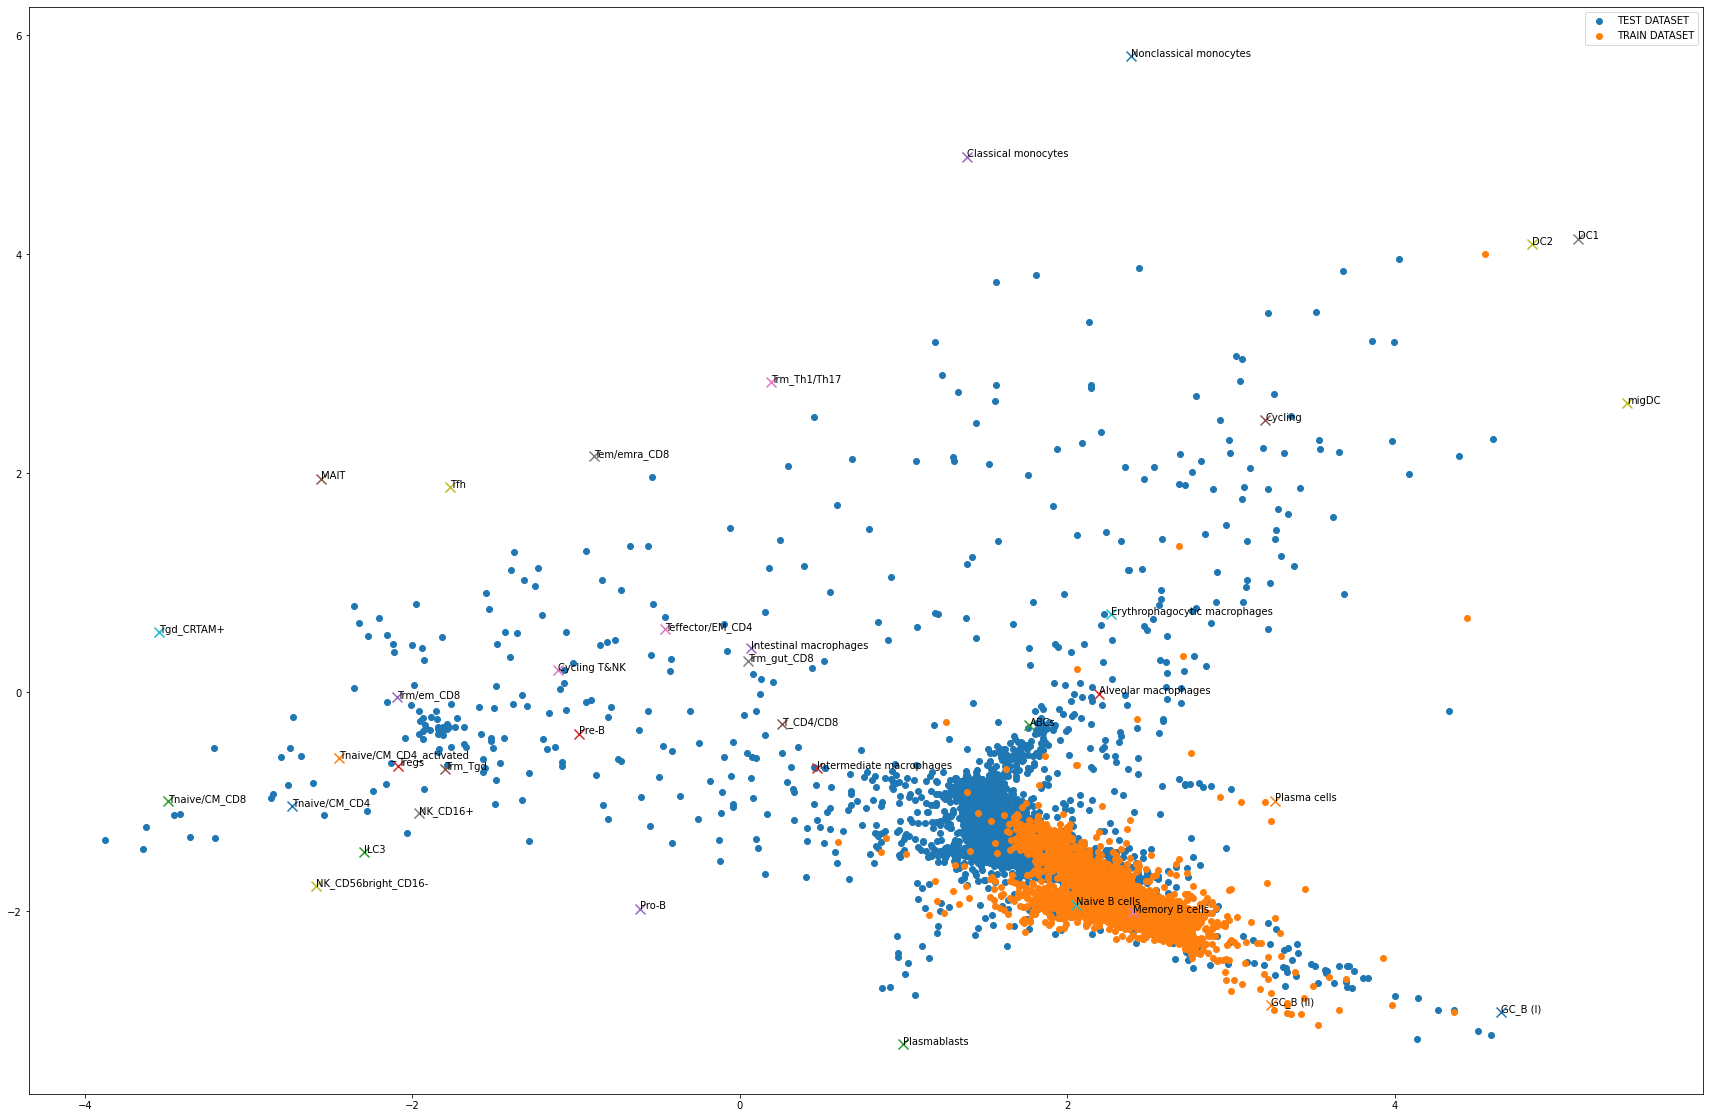

In [7]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Memory B cells', test_celltype='memory B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive naive B cell: 94.08371542671202%
{'Memory B cells': 366, 'ABCs': 11, 'T_CD4/CD8': 7, 'Tnaive/CM_CD4': 3, 'DC2': 2, 'Plasma cells': 2, 'Classical monocytes': 2, 'Plasmablasts': 2, 'Pre-B': 1, 'GC_B (II)': 1, 'Tregs': 1, 'Tem/emra_CD8': 1, 'Cycling': 1}


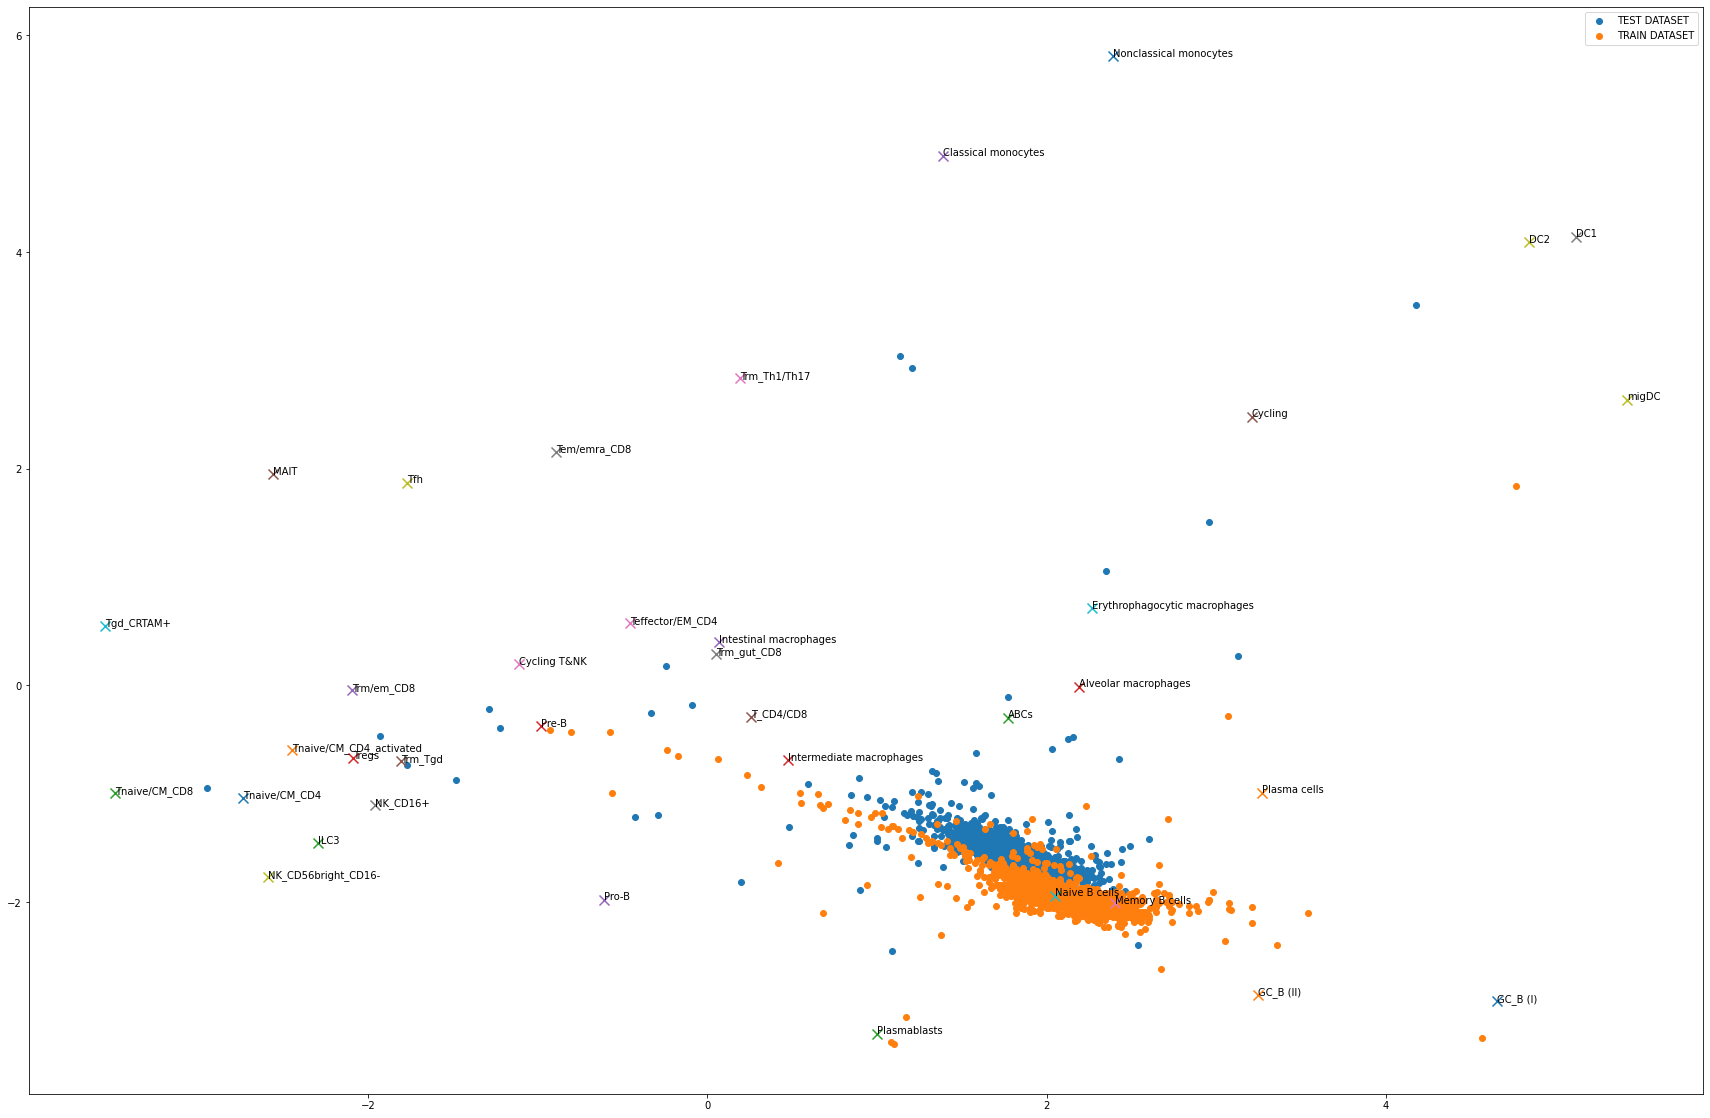

In [8]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Naive B cells', test_celltype='naive B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive T follicular helper cell: 28.894472361809044%
{'Tnaive/CM_CD4': 150, 'Teffector/EM_CD4': 86, 'Trm_Th1/Th17': 23, 'Tregs': 10, 'Tnaive/CM_CD8': 7, 'Trm_gut_CD8': 3, 'T_CD4/CD8': 3, 'Trm/em_CD8': 1}


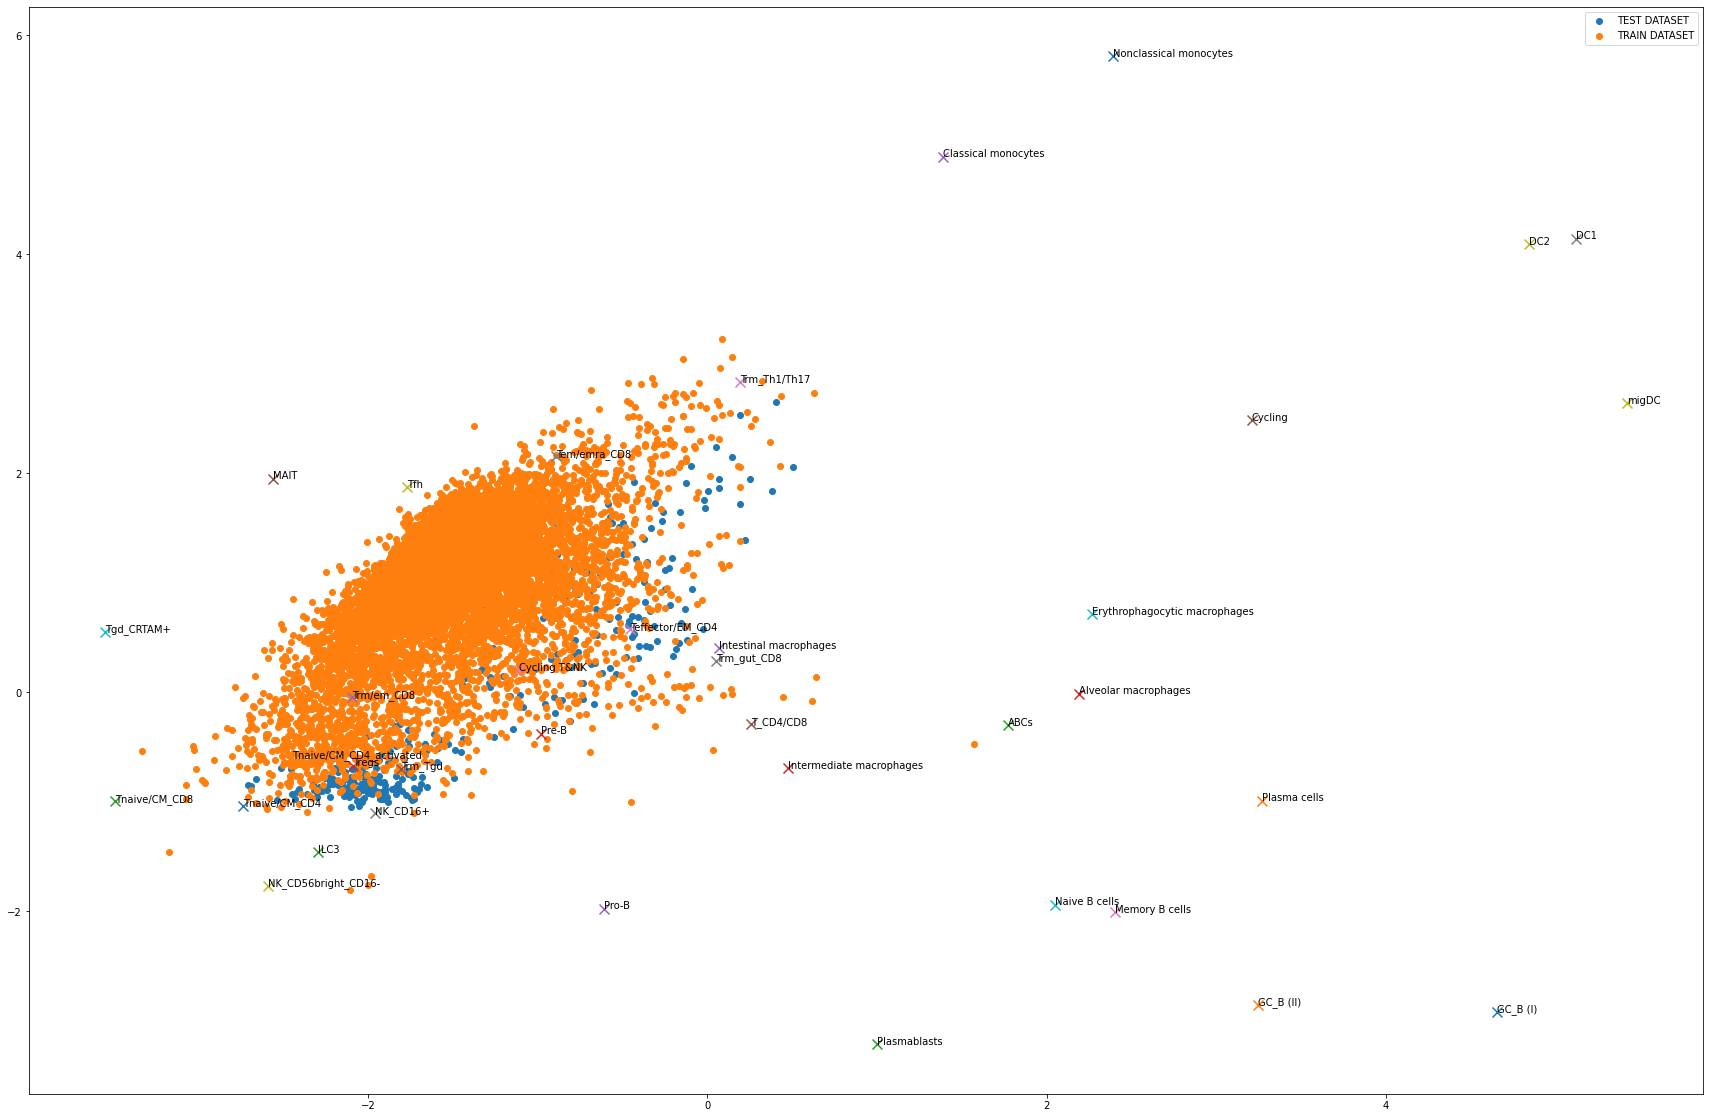

In [9]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Tfh', test_celltype='T follicular helper cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive plasma cell: 56.06756171502815%
{'Plasmablasts': 4191, 'NK_CD16+': 507, 'Memory B cells': 214, 'GC_B (I)': 42, 'NK_CD56bright_CD16-': 31, 'Alveolar macrophages': 19, 'T_CD4/CD8': 14, 'Cycling': 13, 'Classical monocytes': 10, 'Cycling T&NK': 6, 'ABCs': 5, 'Naive B cells': 4, 'Tem/emra_CD8': 4, 'Nonclassical monocytes': 3, 'Trm/em_CD8': 3, 'Trm_Th1/Th17': 2, 'Pro-B': 1, 'Intermediate macrophages': 1, 'ILC3': 1, 'DC2': 1}


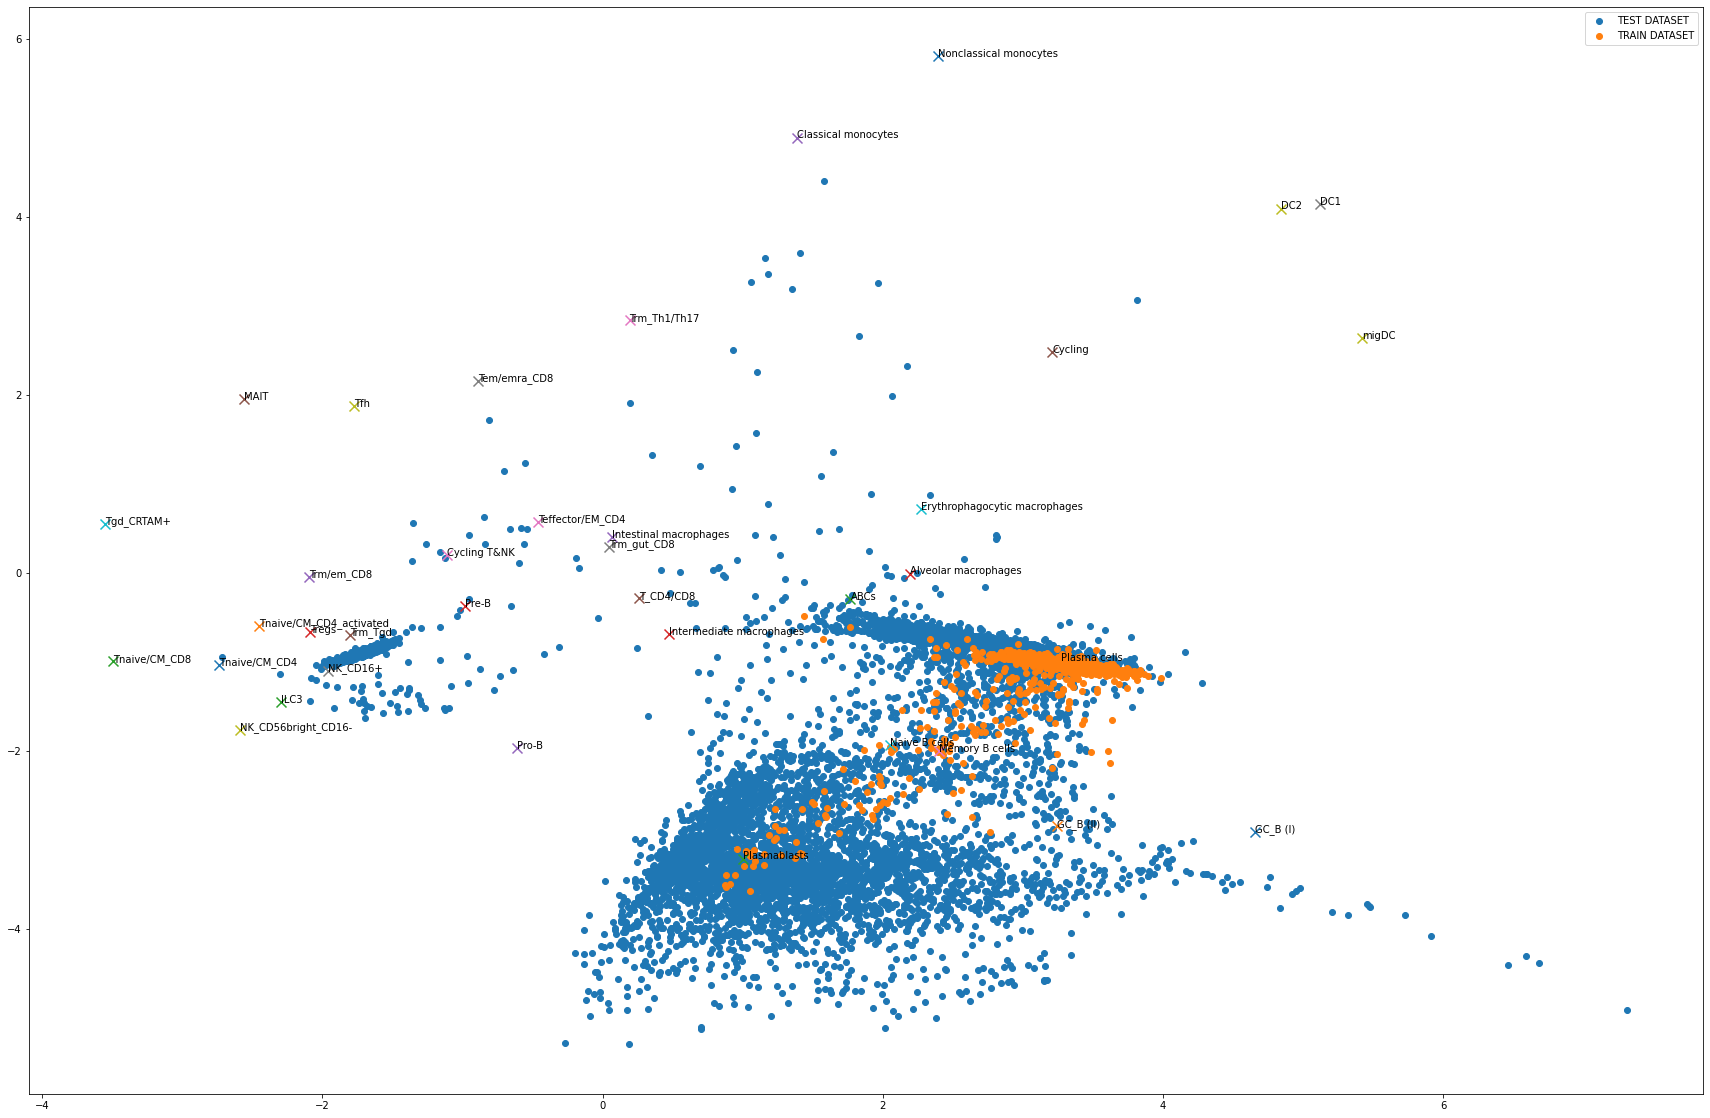

In [10]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Plasma cells', test_celltype='plasma cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive regulatory T cell: 82.65541059094397%
{'Cycling T&NK': 65, 'Tfh': 40, 'Teffector/EM_CD4': 34, 'Tnaive/CM_CD4': 27, 'Memory B cells': 16, 'T_CD4/CD8': 11, 'Trm/em_CD8': 9, 'Trm_Th1/Th17': 7, 'Tgd_CRTAM+': 3, 'MAIT': 3, 'NK_CD56bright_CD16-': 2, 'ILC3': 2, 'Tnaive/CM_CD8': 2, 'Tnaive/CM_CD4_activated': 1, 'Classical monocytes': 1, 'Plasma cells': 1, 'Pro-B': 1, 'Tem/emra_CD8': 1}


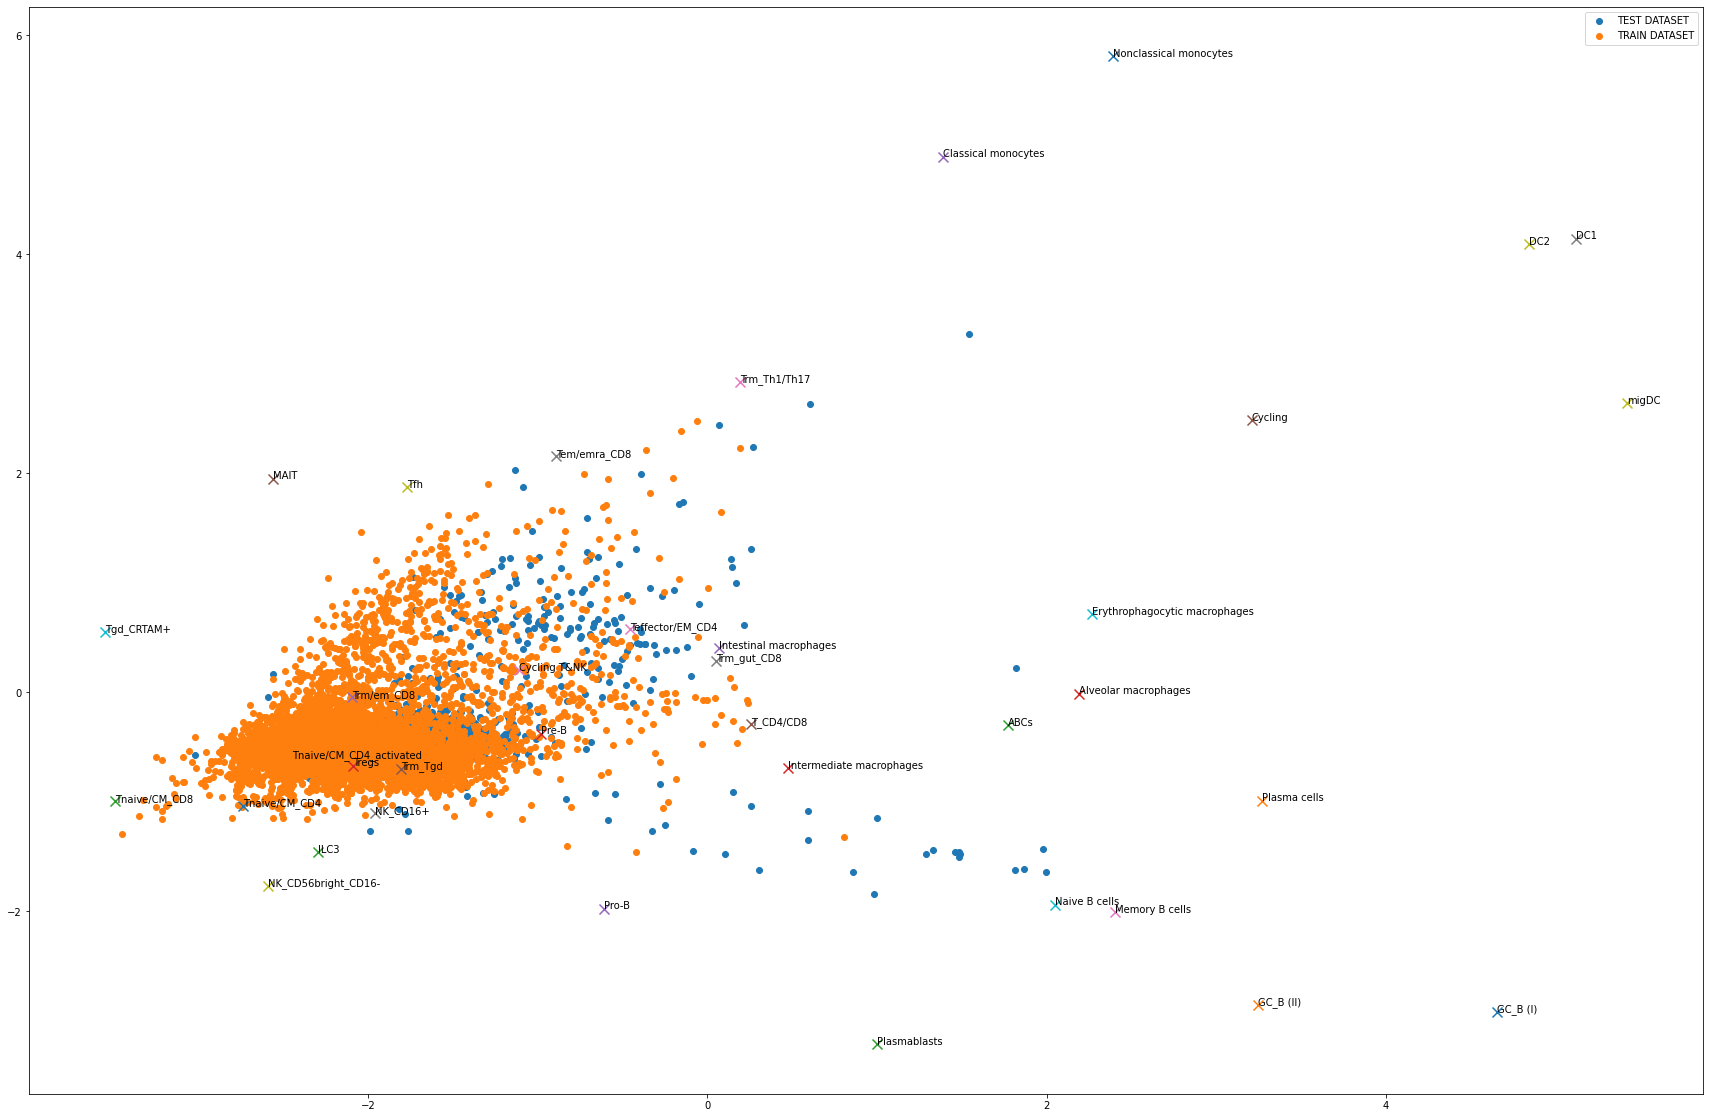

In [11]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Tregs', test_celltype='regulatory T cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

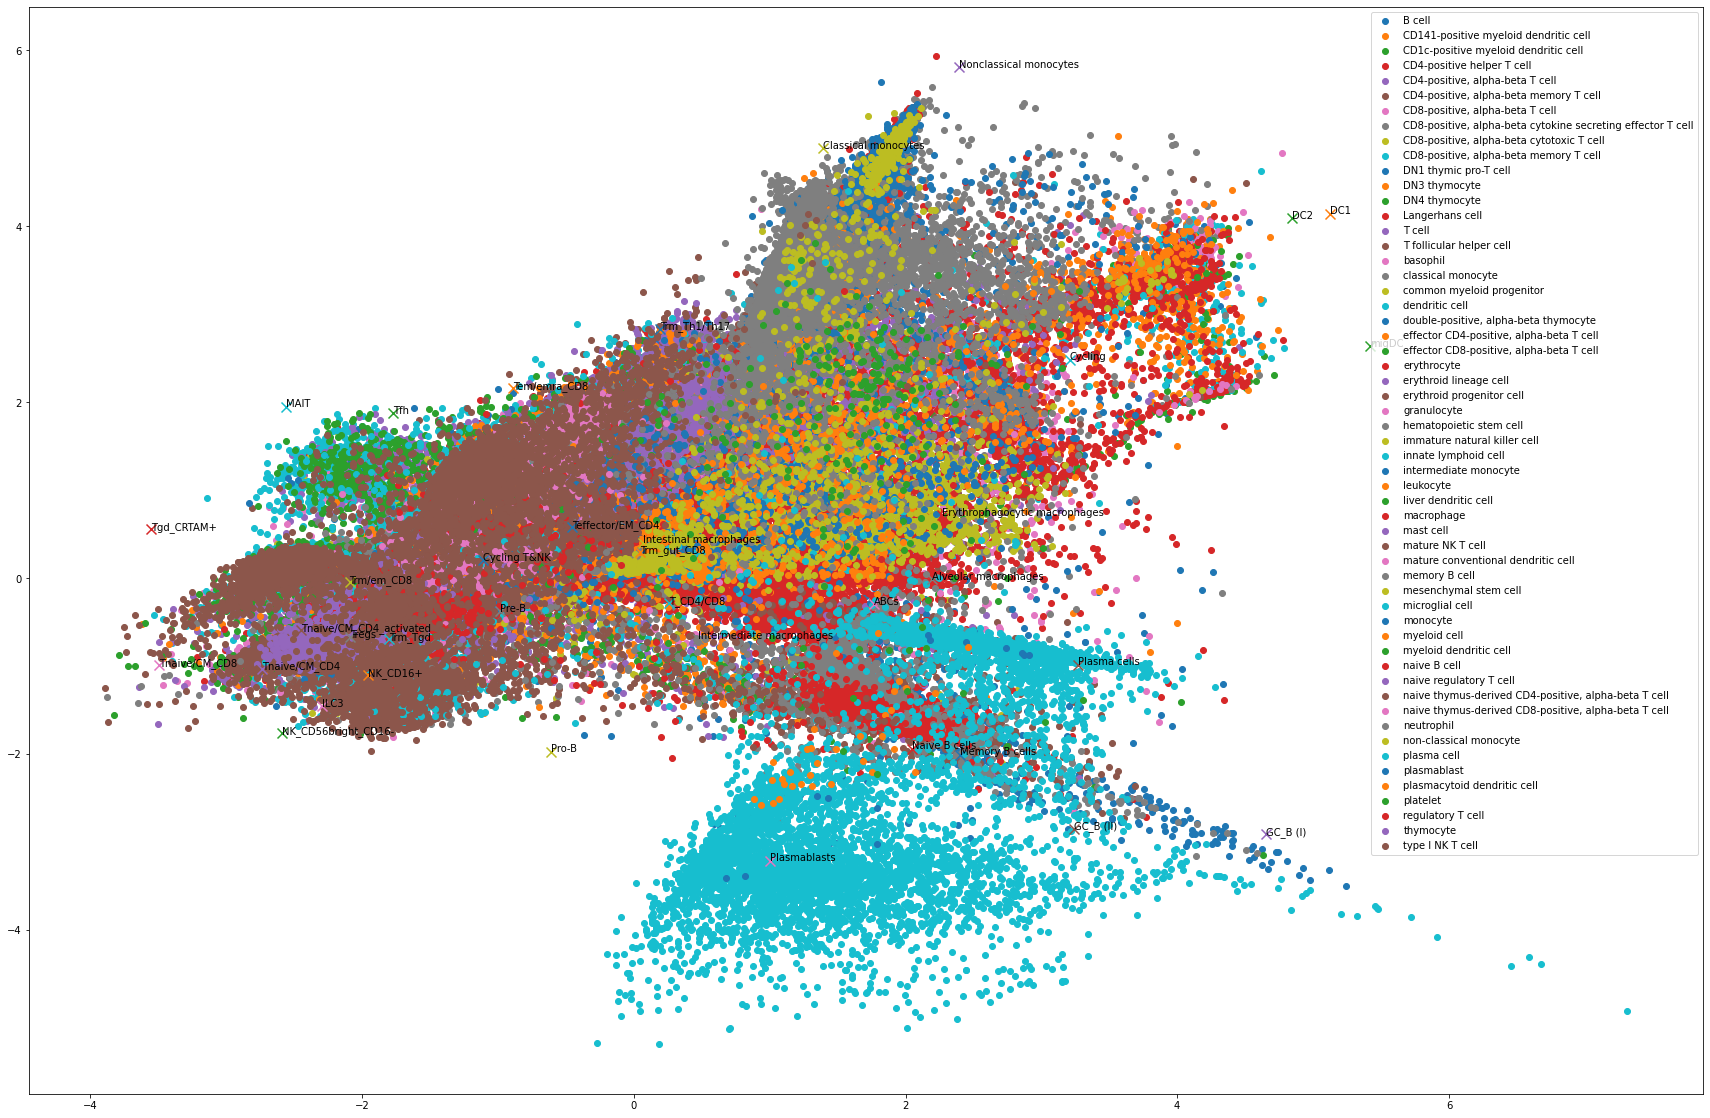

In [12]:
helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_popv_pca.obs['cell_type'], 
    embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

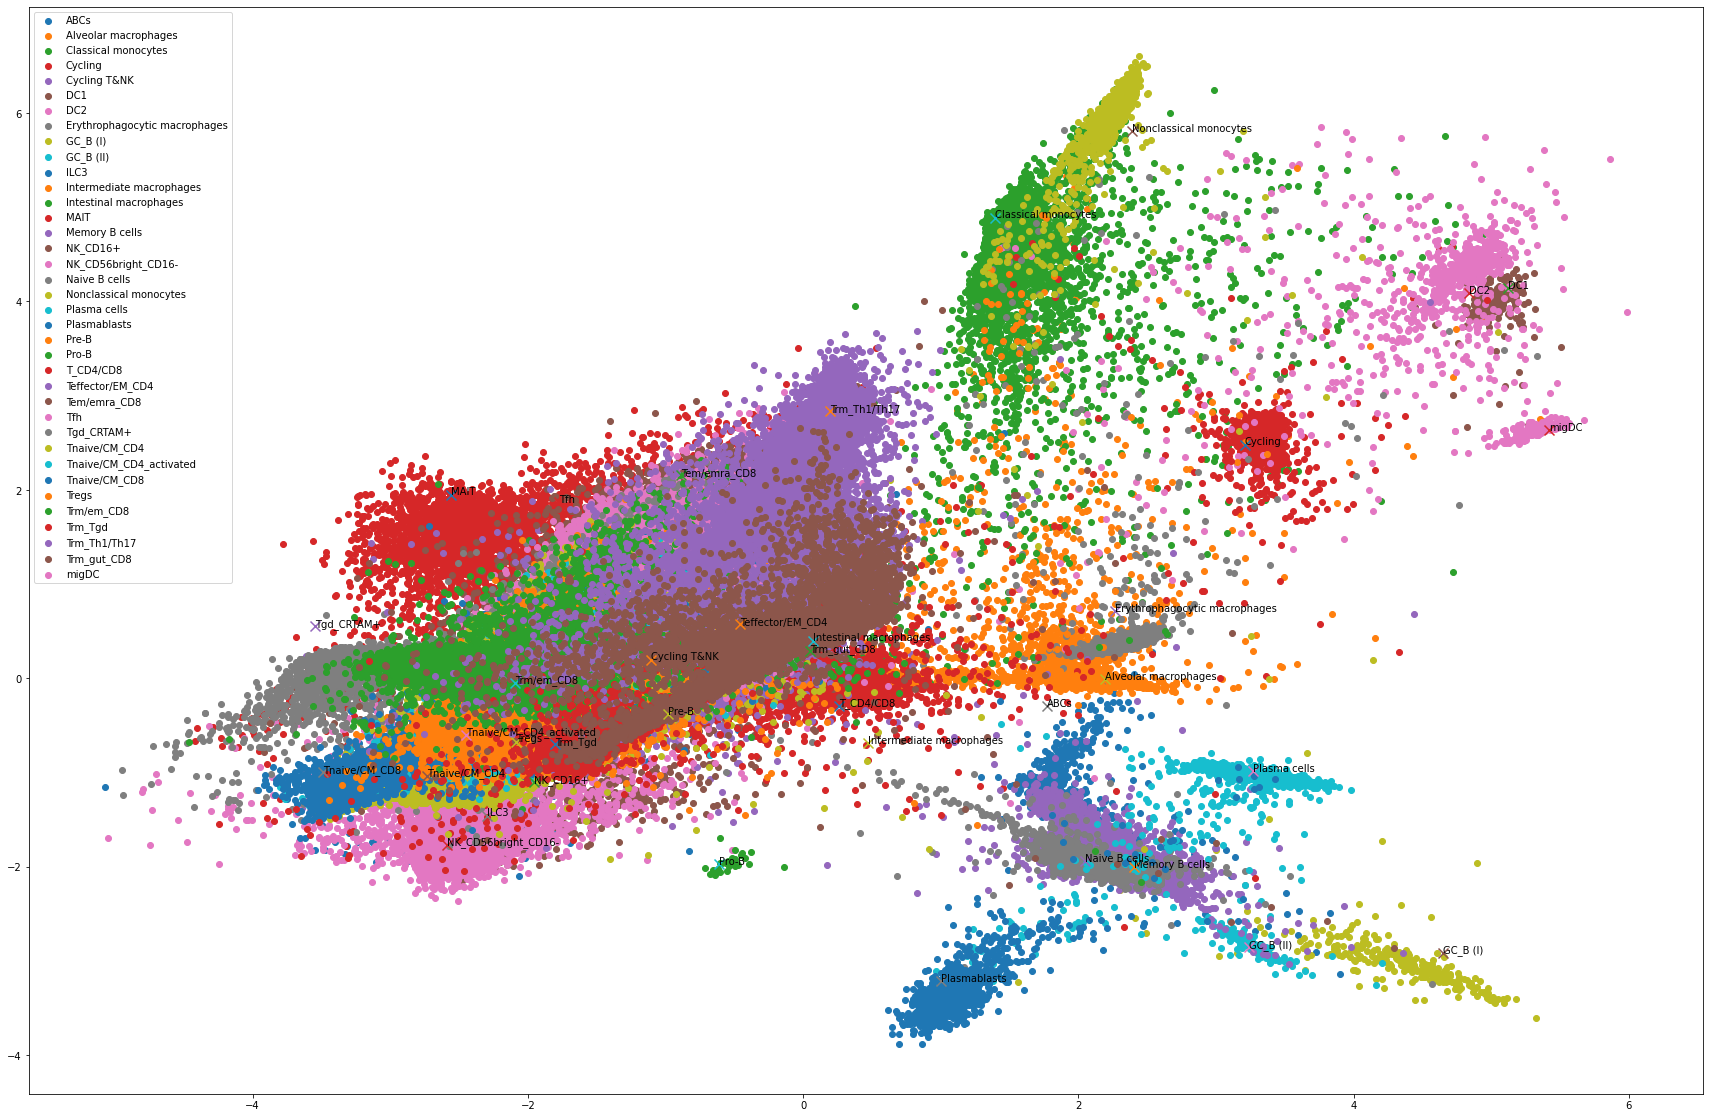

In [13]:
helper_fns.plot_embeddings_scatter(embeddings=train_embeddings, true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], 
    embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

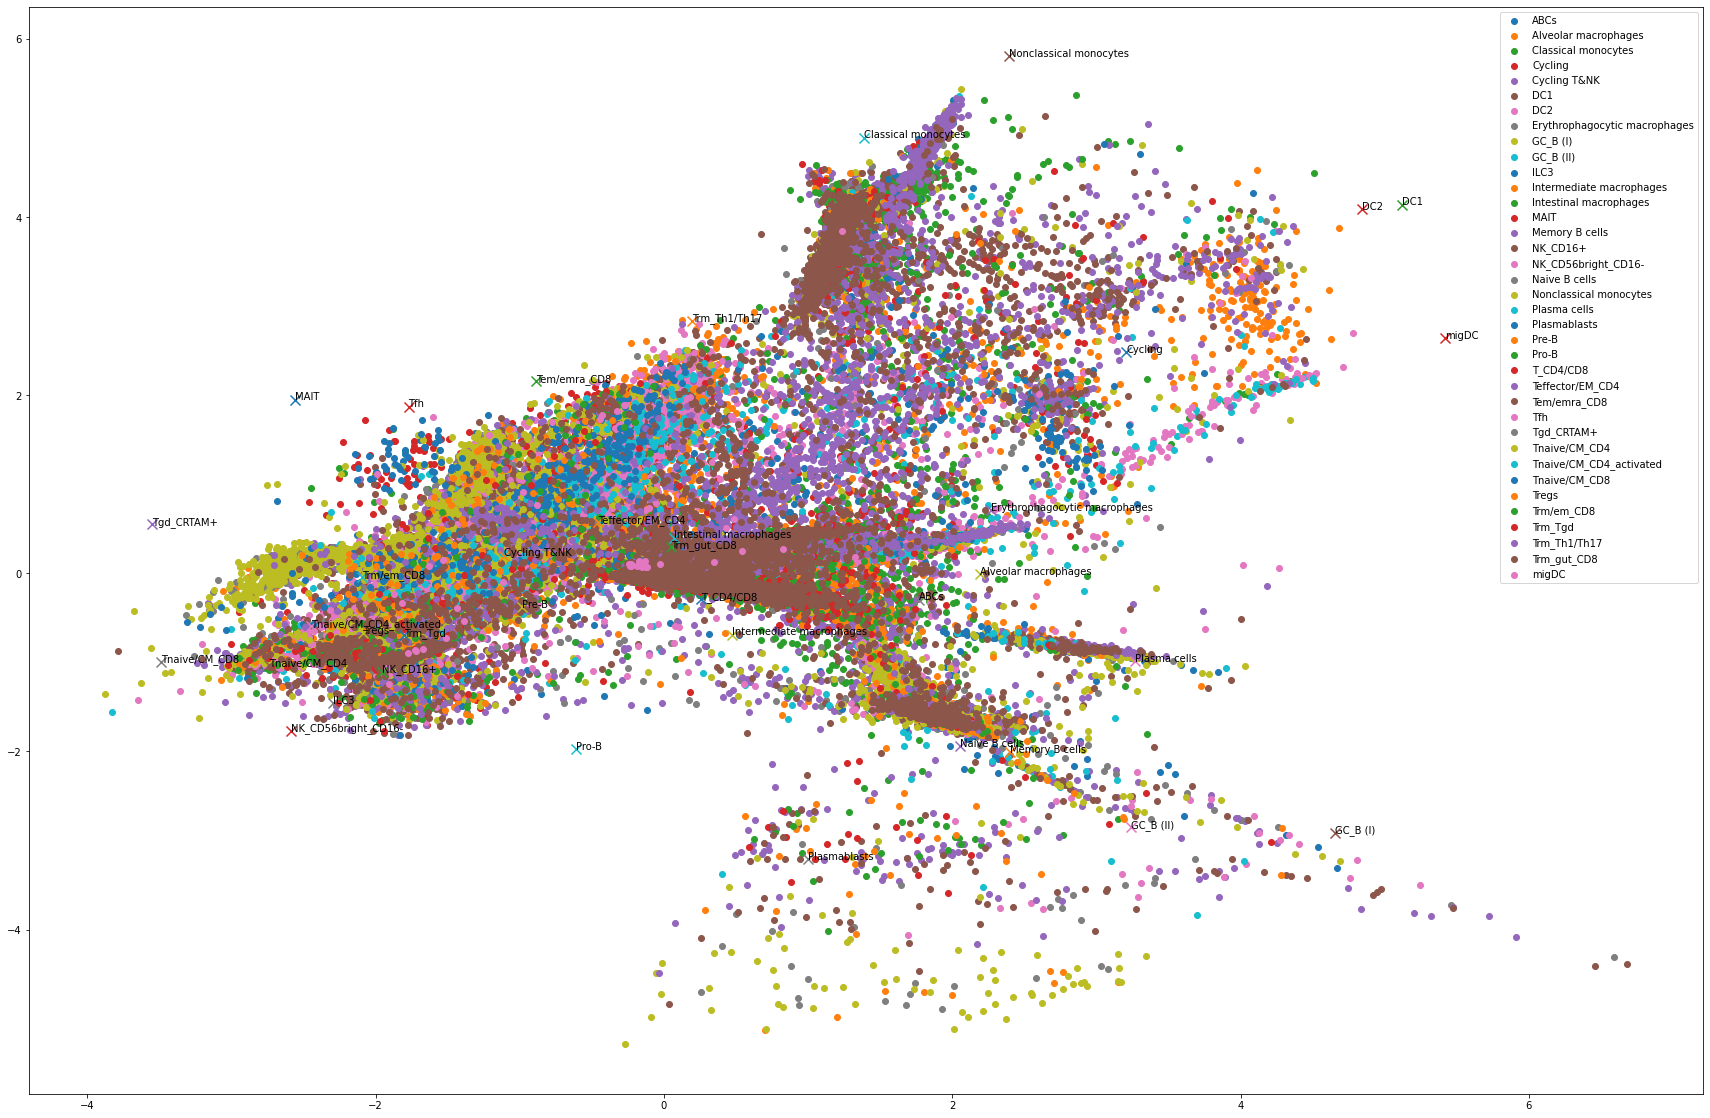

In [14]:
helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype'], 
    embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

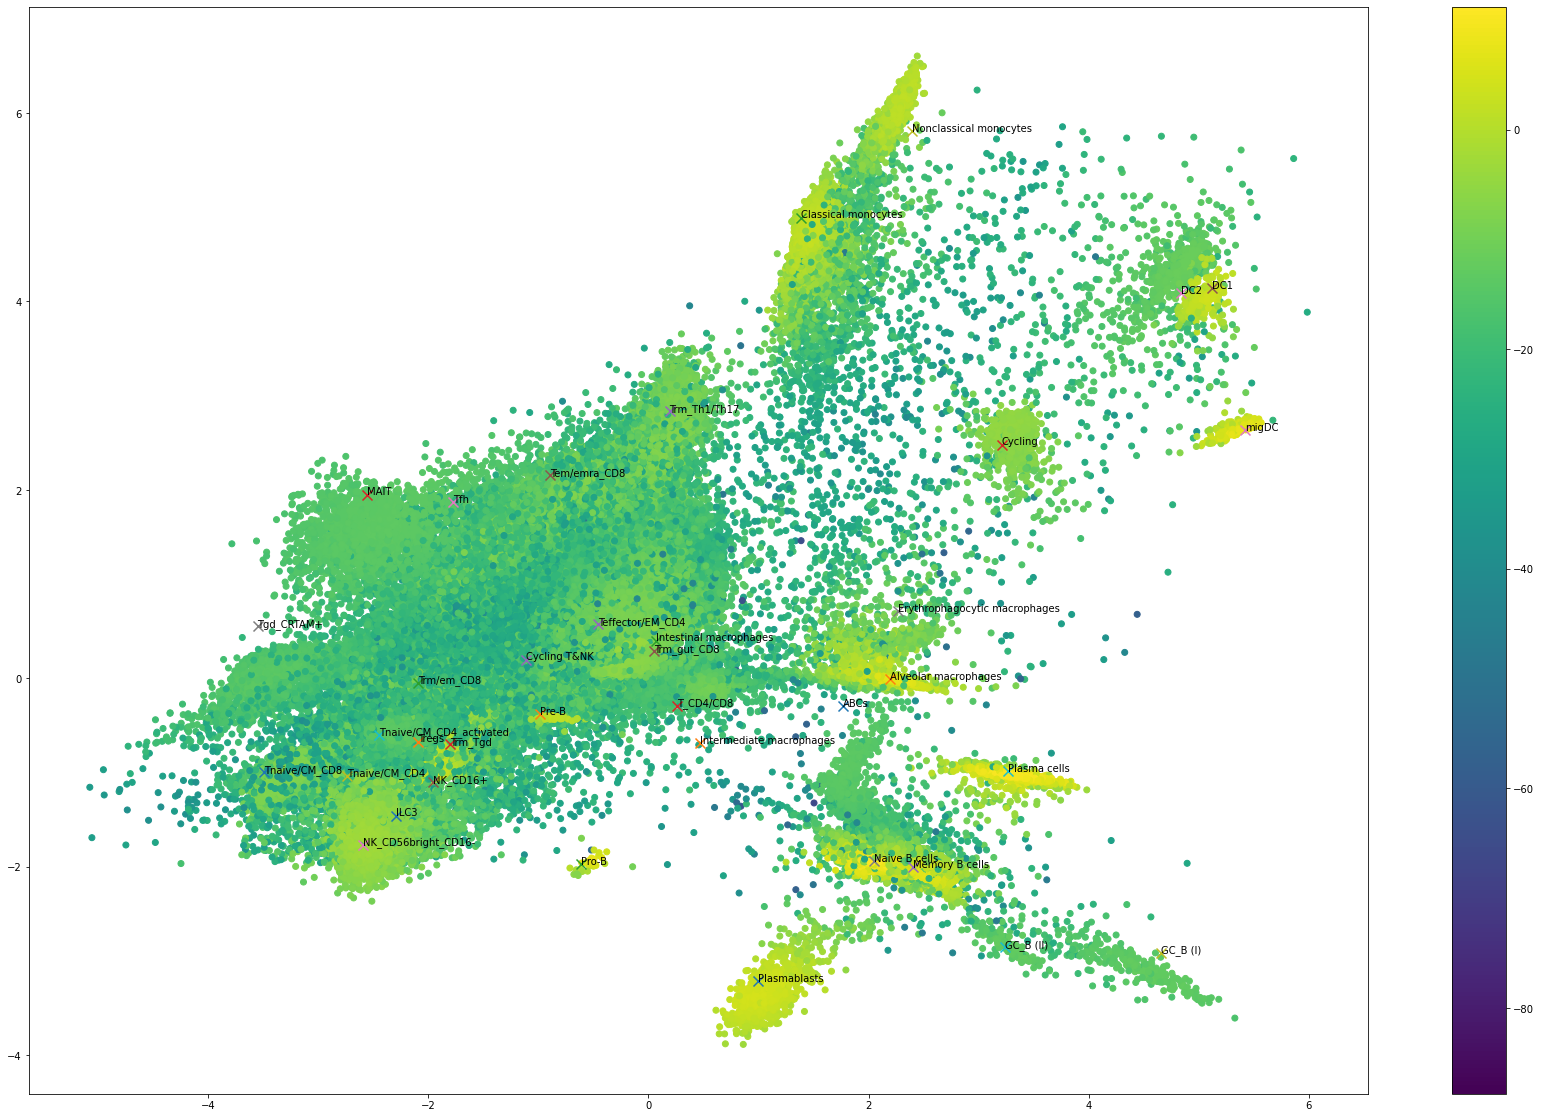

In [15]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=training_preds, 
    embeddings=train_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

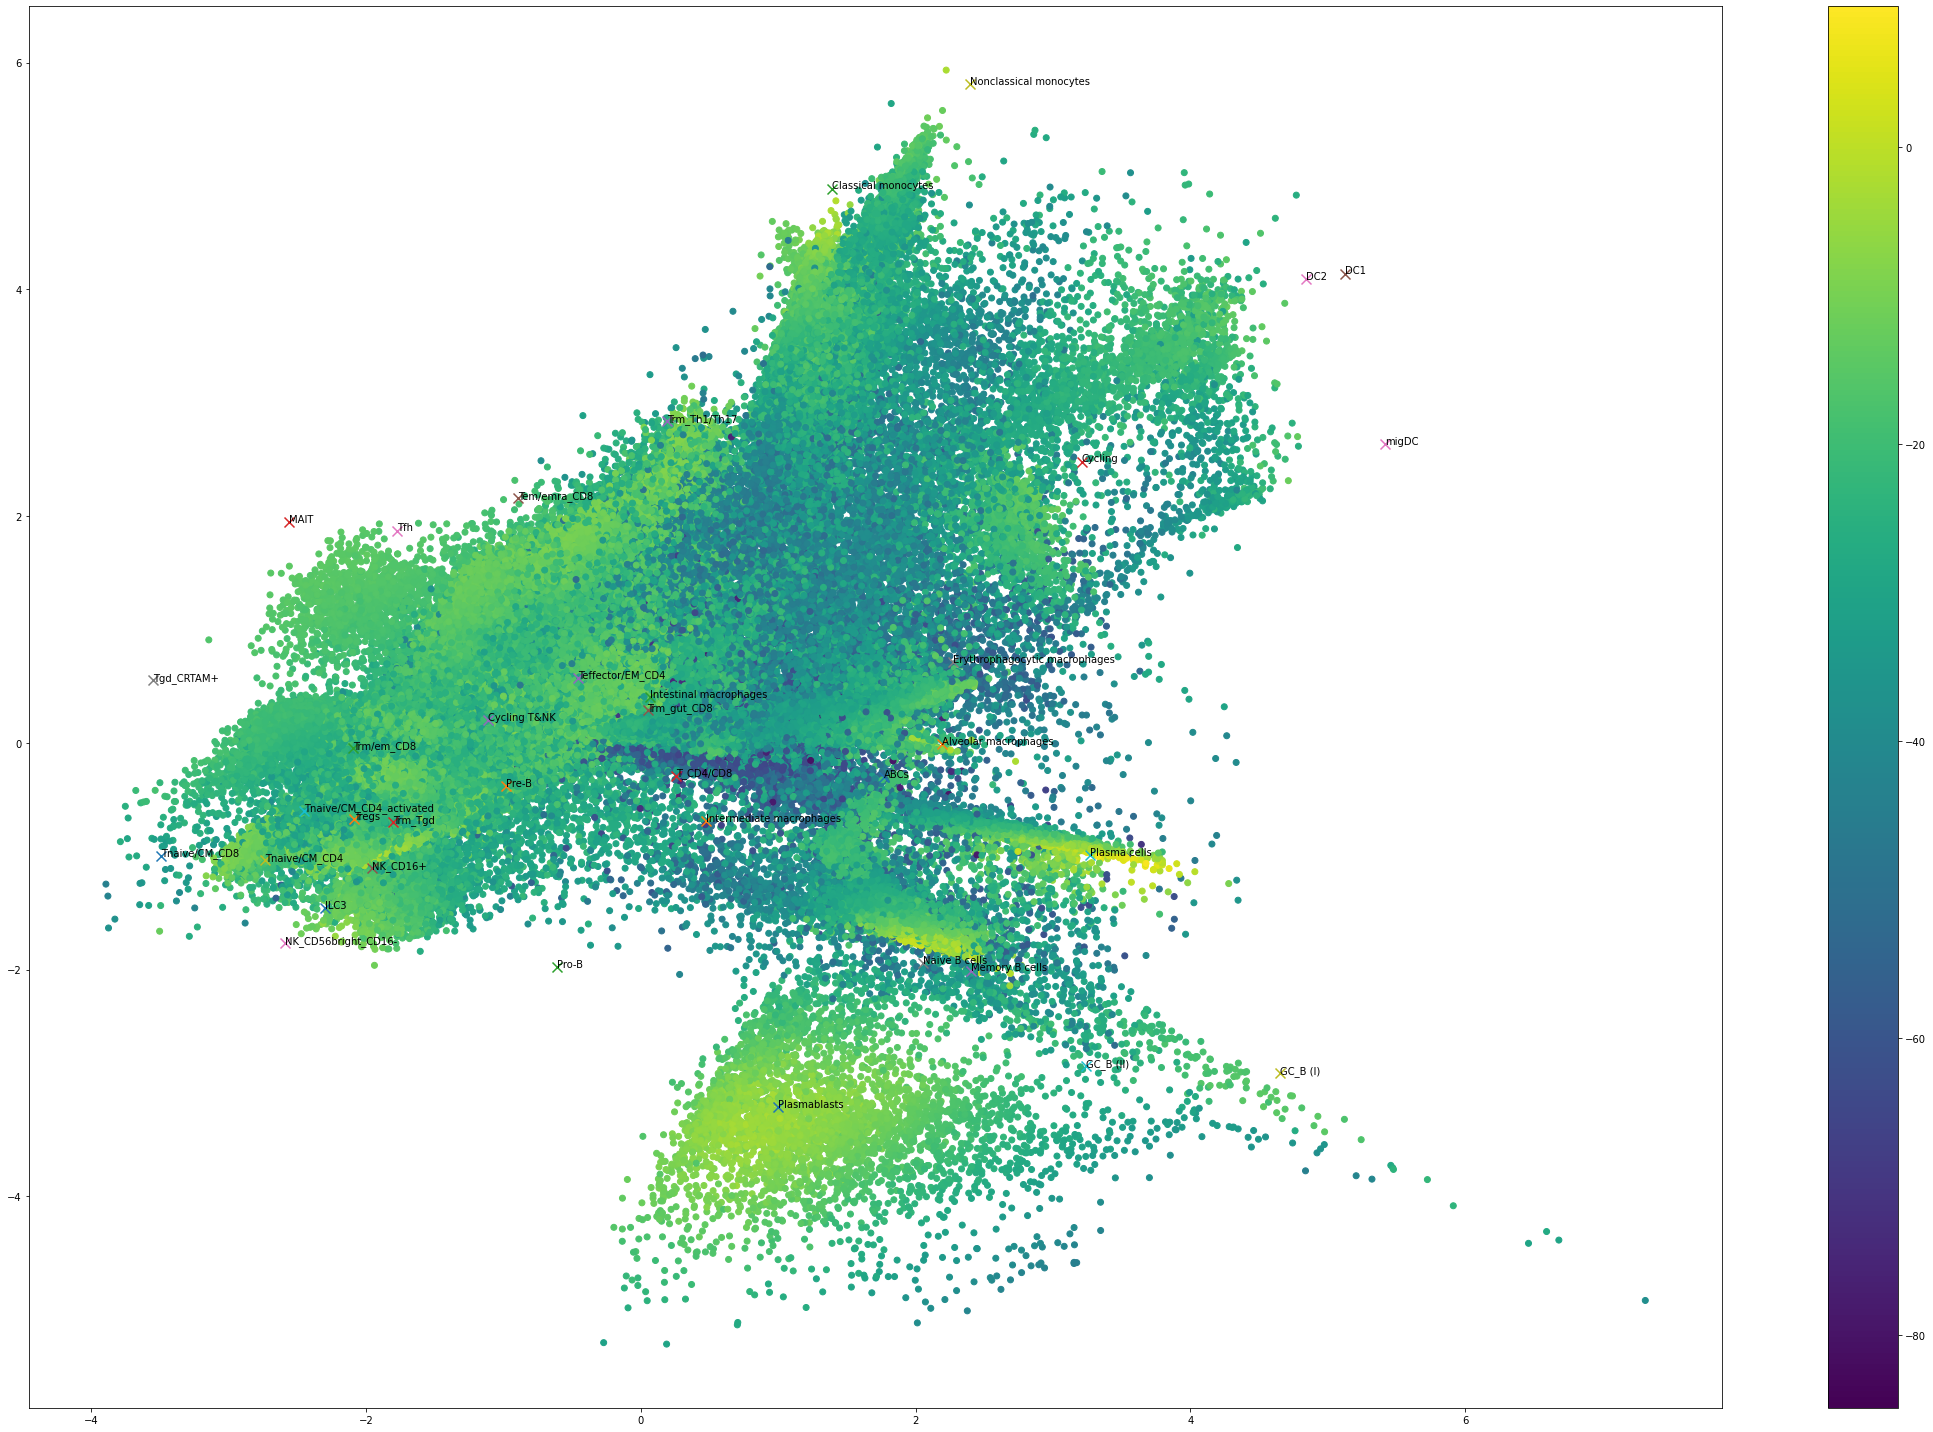

In [16]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=test_preds, 
    embeddings=test_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [17]:
print("OUR MODEL")
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

print('\n')
print("Logistic Regression")
test_preds_logistic = encoder_celltype.inverse_transform(model_logistic.predict(dataset_popv_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds_logistic, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

print('\n')
print("kNN")
test_preds_knn = encoder_celltype.inverse_transform(model_knn.predict(dataset_popv_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_popv_pca.obs['cell_type'], test_pred_labels=test_preds_knn, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

OUR MODEL


True positive memory B cell: 85.90201582036234%
{'Naive B cells': 790, 'ABCs': 959, 'DC2': 53, 'Tnaive/CM_CD4': 3, 'Pro-B': 5, 'Tregs': 39, 'Tfh': 20, 'Plasma cells': 37, 'T_CD4/CD8': 88, 'ILC3': 5, 'Teffector/EM_CD4': 9, 'Trm/em_CD8': 1, 'Tnaive/CM_CD8': 5, 'GC_B (II)': 40, 'Erythrophagocytic macrophages': 6, 'GC_B (I)': 37, 'Pre-B': 11, 'Cycling': 21, 'migDC': 4, 'Intestinal macrophages': 3, 'Classical monocytes': 11, 'Alveolar macrophages': 5, 'DC1': 2, 'Tem/emra_CD8': 10, 'Plasmablasts': 45, 'Cycling T&NK': 1}


True positive naive B cell: 94.08371542671202%
{'Memory B cells': 366, 'Pre-B': 1, 'T_CD4/CD8': 7, 'ABCs': 11, 'DC2': 2, 'Tnaive/CM_CD4': 3, 'Plasma cells': 2, 'GC_B (II)': 1, 'Tregs': 1, 'Tem/emra_CD8': 1, 'Classical monocytes': 2, 'Plasmablasts': 2, 'Cycling': 1}


True positive T follicular helper cell: 28.894472361809044%
{'Teffector/EM_CD4': 86, 'Tnaive/CM_CD4': 150, 'Trm_Th1/Th17': 23, 'Tregs': 10, 'Tnaive/CM_CD8': 7, 'Trm_gut_CD8': 3, 'T_CD4/CD8': 3, 'Trm